In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations



In [2]:
# ============================================================
# Load
# ============================================================
BASE = Path.cwd().resolve()
DATA_DIR = BASE.parents[1] / "data" / "processed"
df = pd.read_csv(DATA_DIR / "train_monthly_v2.csv")

df = df.sort_values(["item_id", "year", "month"])
df["t"] = (df["year"] - df["year"].min()) * 12 + df["month"]

# pivot: (item × time) → value
ts_val = df.pivot(index="item_id", columns="t", values="total_value").fillna(0)
items = ts_val.index.tolist()

print("ts_val shape:", ts_val.shape)


ts_val shape: (100, 43)


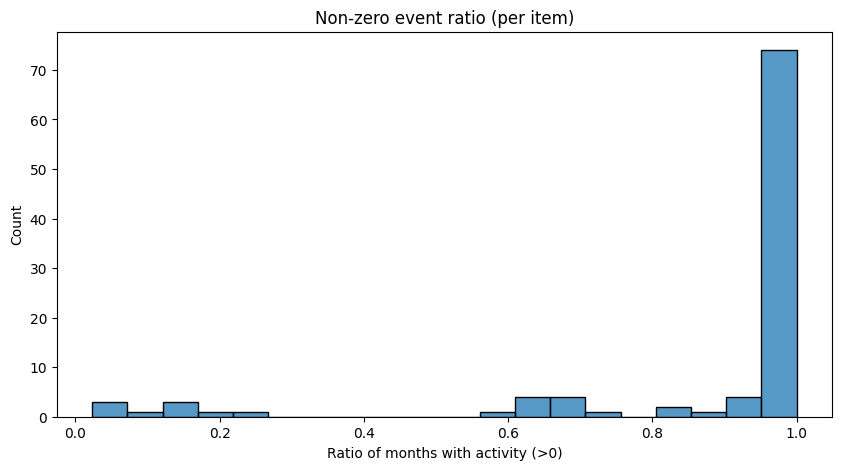

In [3]:
# 이벤트 매트릭스 (0/1)
event = (ts_val > 0).astype(int)

# 아이템별 non-zero 비율
event_ratio = event.mean(axis=1).sort_values()

plt.figure(figsize=(10,5))
sns.histplot(event_ratio, bins=20)
plt.title("Non-zero event ratio (per item)")
plt.xlabel("Ratio of months with activity (>0)")
plt.show()


In [4]:
# 각 item의 event-run-length 알아보기
run_lengths = {}

for item in items:
    seq = event.loc[item].values
    runs = []

    cnt = 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            cnt += 1
        else:
            runs.append((seq[i-1], cnt))
            cnt = 1
    runs.append((seq[-1], cnt))
    run_lengths[item] = runs

# 예: run_lengths["ITEM123"] → [(0,3),(1,1),(0,2),(1,1),...]


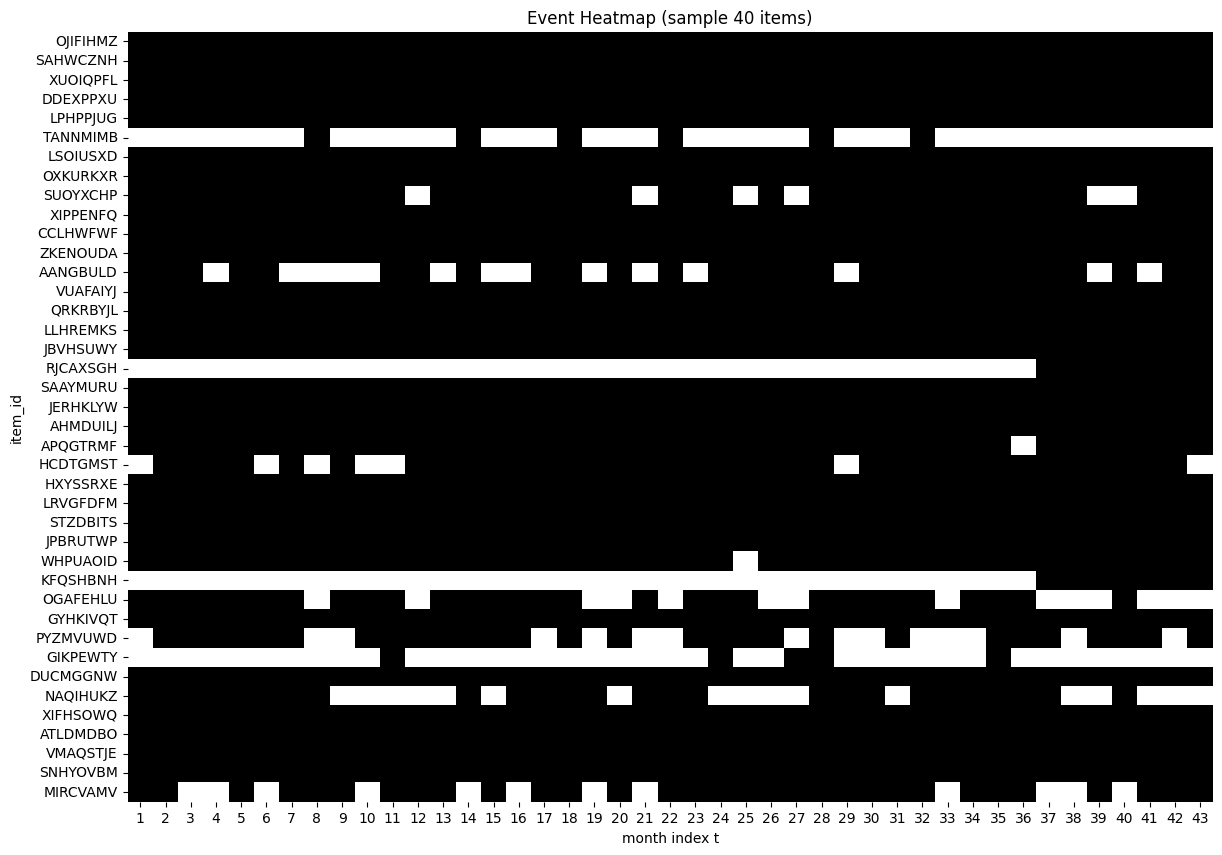

In [5]:
plt.figure(figsize=(14, 10))
sns.heatmap(event.sample(40), cmap="Greys", cbar=False)
plt.title("Event Heatmap (sample 40 items)")
plt.xlabel("month index t")
plt.show()


In [6]:
from sklearn.cluster import KMeans

k = 4
km = KMeans(n_clusters=k, random_state=42)
cluster_event = km.fit_predict(event)

event_df = pd.DataFrame({"item_id": items, "event_cluster": cluster_event})
print(event_df.head())


    item_id  event_cluster
0  AANGBULD              3
1  AHMDUILJ              0
2  ANWUJOKX              2
3  APQGTRMF              0
4  ATLDMDBO              0


In [7]:
pair_records = []
for i, j in combinations(items, 2):
    e_i, e_j = event.loc[i].values, event.loc[j].values
    
    # 동시 발생
    both_on = ((e_i == 1) & (e_j == 1)).sum()
    both_off = ((e_i == 0) & (e_j == 0)).sum()
    
    # lead-lag event
    lead_i = ((e_i[:-1] == 1) & (e_j[1:] == 1)).sum()
    lead_j = ((e_j[:-1] == 1) & (e_i[1:] == 1)).sum()
    
    pair_records.append([i, j, both_on, both_off, lead_i, lead_j])

event_pair = pd.DataFrame(pair_records, 
    columns=["item_i","item_j","both_on","both_off","lead_i","lead_j"])

print(event_pair.head())


     item_i    item_j  both_on  both_off  lead_i  lead_j
0  AANGBULD  AHMDUILJ       29         0      28      28
1  AANGBULD  ANWUJOKX        5        11       4       5
2  AANGBULD  APQGTRMF       28         0      27      27
3  AANGBULD  ATLDMDBO       29         0      28      28
4  AANGBULD  AXULOHBQ       29         0      28      28


In [8]:
pair_records = []
for i, j in combinations(items, 2):
    e_i, e_j = event.loc[i].values, event.loc[j].values
    
    # 동시 발생
    both_on = ((e_i == 1) & (e_j == 1)).sum()
    both_off = ((e_i == 0) & (e_j == 0)).sum()
    
    # lead-lag event
    lead_i = ((e_i[:-1] == 1) & (e_j[1:] == 1)).sum()
    lead_j = ((e_j[:-1] == 1) & (e_i[1:] == 1)).sum()
    
    pair_records.append([i, j, both_on, both_off, lead_i, lead_j])

event_pair = pd.DataFrame(pair_records, 
    columns=["item_i","item_j","both_on","both_off","lead_i","lead_j"])

print(event_pair.head())


     item_i    item_j  both_on  both_off  lead_i  lead_j
0  AANGBULD  AHMDUILJ       29         0      28      28
1  AANGBULD  ANWUJOKX        5        11       4       5
2  AANGBULD  APQGTRMF       28         0      27      27
3  AANGBULD  ATLDMDBO       29         0      28      28
4  AANGBULD  AXULOHBQ       29         0      28      28


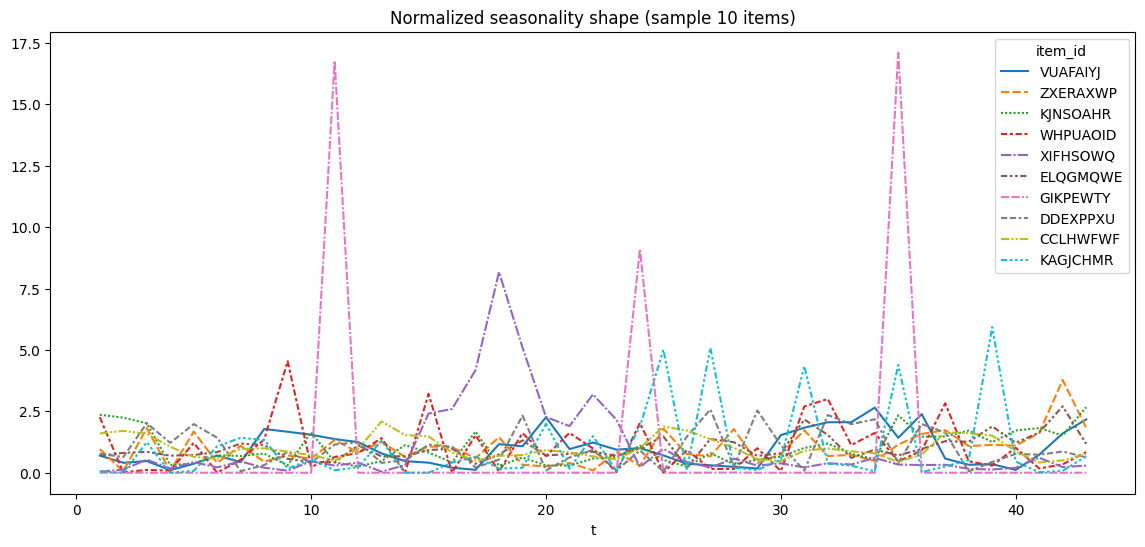

In [9]:
norm_val = ts_val.div(ts_val.mean(axis=1).replace(0,1), axis=0).fillna(0)

plt.figure(figsize=(14,6))
sns.lineplot(data=norm_val.sample(10).T)
plt.title("Normalized seasonality shape (sample 10 items)")
plt.xlabel("t")
plt.show()


In [10]:
from scipy.spatial.distance import cosine

pattern_pairs = []
for i,j in combinations(items, 2):
    a = norm_val.loc[i].values
    b = norm_val.loc[j].values
    cos = 1 - cosine(a, b)
    pattern_pairs.append([i, j, cos])

pattern_df = pd.DataFrame(pattern_pairs, columns=["item_i","item_j","pattern_cos"])


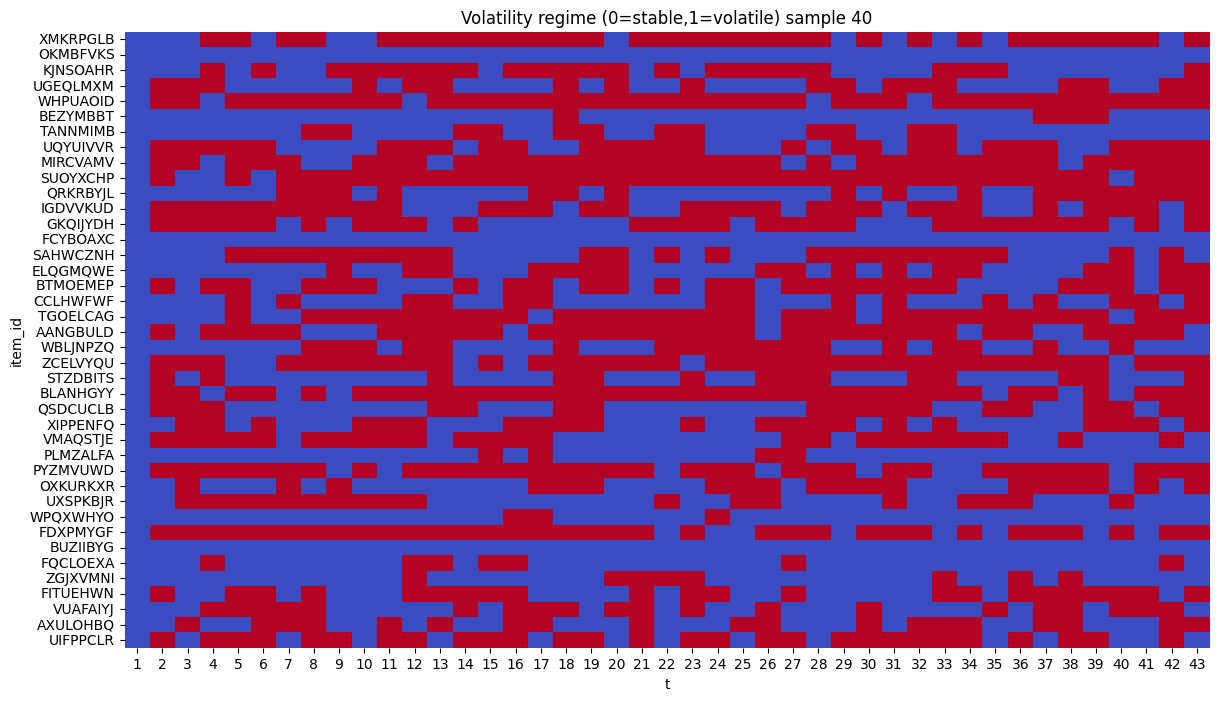

In [11]:
diff_log = np.log1p(ts_val).diff(axis=1).fillna(0)

regime = (diff_log.abs() > diff_log.abs().median()).astype(int)

plt.figure(figsize=(14,8))
sns.heatmap(regime.sample(40), cmap="coolwarm", cbar=False)
plt.title("Volatility regime (0=stable,1=volatile) sample 40")
plt.show()


In [12]:
reg_pairs = []
for i,j in combinations(items,2):
    r_i = regime.loc[i].values
    r_j = regime.loc[j].values
    agree = (r_i == r_j).mean()
    reg_pairs.append([i,j,agree])

reg_pair = pd.DataFrame(reg_pairs, columns=["item_i","item_j","regime_agree"])
